# Biological Productivity

The notebook integrates NPP over depth, creates the corresponding visualisations and calculates the differences between MR and HR (chapter 3.3.2). The following figures are created in this notebook:
- Figure 3.16: Spatial distribution of NPP
- Figure 3.17: Relative change of NPP with distance from coast
- Figure 3.18: Hovmöller diagram of NPP
- Figure A.11: Temporal evolution of NPP difference

In [1]:
import sys
sys.path.append('/nfs/kryo/work/maxsimon/master-thesis/scripts/')

import os

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from romstools.romsrun import RomsRun
from romstools.plot import plot_data
from romstools.utils import p, cache, np_rolling_mean, mean_with_error, ratio_with_error
from romstools.cmap import DIFF, DIFF_r, W2G, W2G_r, G2R, G2R_r, get_step_cmap

import scipy.signal as sig
import scipy.stats as stat

import cartopy.crs as ccrs

import warnings
from datetime import timedelta as tdelta

import matplotlib.animation as animation
from matplotlib import rc
from matplotlib.cm import get_cmap

## Load Data

In [2]:
## pactcs30

# setup run
meso = RomsRun('/nfs/kryo/work/maxsimon/data/pactcs30/grid.nc')
# add tot_prod data
meso.add_data('/nfs/kryo/work/maxsimon/data/pactcs30/climatologies/z_data-1d.nc')
# add zlevel data
meso.add_data('/nfs/kryo/work/maxsimon/data/pactcs30/z/z_levels.nc')

# add additional grid data
data = np.load('/nfs/kryo/work/maxsimon/data/pactcs30/grid.npz', allow_pickle=True)
meso.distance_map = data['distance_map']
meso.distance_lines = data['distance_lines']
meso.gruber_mask = data['gruber_mask']

In [3]:
## pactcs15

# setup run
subm = RomsRun('/nfs/kryo/work/maxsimon/data/pactcs15/grid.nc')
# add tot_prod data
subm.add_data('/nfs/kryo/work/maxsimon/data/pactcs15/climatologies/z_data-1d.nc')
# add zlevel data
subm.add_data('/nfs/kryo/work/maxsimon/data/pactcs15/z/z_levels.nc')

# add additional grid data
data = np.load('/nfs/kryo/work/maxsimon/data/pactcs15/grid.npz', allow_pickle=True)
subm.distance_map = data['distance_map']
subm.distance_lines = data['distance_lines']
subm.gruber_mask = data['gruber_mask']

In [4]:
# runs as dictionaries
runs = {
    'pactcs15': subm,
    'pactcs30': meso
}

# names for plot
names = {
    'pactcs15': 'HR',
    'pactcs30': 'MR'
}

In [5]:
## load satellite data
ds = xr.open_dataset('/nfs/kryo/work/updata/SeaWiFS_NPP/standard_VGPM/vgpm.1998-2007.monthly_clim.nc')

# cut domain such that it fits to the chosen subdomain
ds_gruber_2011 = ds.where(
    xr.ufuncs.logical_and(
        xr.ufuncs.logical_and(ds.Lat >= 28, ds.Lat <= 46),
        xr.ufuncs.logical_and(ds.Lon >= -140, ds.Lon <= -115)
    ), drop=True
)

# units mgC m-2 day-1
# to get mol /m2 /yr
# use 1 g C = 0.08326 mol
factor = 365*0.08326/1000 # mgC --> mol (1 g C = 0.08326 mol) 
seawifs_npp = ds_gruber_2011.npp.values * factor

## Calculate NPP

NPP is calculated by integrating `TOT_PROD` over depth. Units of `TOT_PROD` are mmol/m$^3$/s, after integration mmol/m$^2$/s. To get mol/m$^2$/yr, the result is multiplied by 31536000 s/yr (which is 1) and devided by 1000. All in all, the factor is 31536.

In [6]:
def calc_npp(run, var='TOT_PROD', factor=31536, skip_years=0):
    """
    Function to calculate NPP integrated over depth from raw ROMS output and from climatology
    """
    
    if getattr(run, var+'_b', None) is not None:
        print('Dataset is climatology')
        # multiply thickness
        tot_prod_integrated_t = run[var + '_b'] * run.thickness_z * factor
        # sum up ( --> integrated)
        tot_prod_integrated_t = tot_prod_integrated_t.sum(dim=run._depth_key)
        # return
        return tot_prod_integrated_t.values
        
    else:
        print('Dataset is raw data...')
        # create dummy object
        tot_prod_integrated_t = np.zeros((365, run[var].shape[2], run[var].shape[3])).astype(float)
        # counter for getting the number of items per doy
        num_items = np.zeros((365,))
        
        for t_obj, prod in run.get_iterator('time', var):
            # skip first two years
            if t_obj.year <= skip_years:
                continue
            doy = t_obj.dayofyr - 1
            # multiply with depth and sum up
            prod_integrated = (prod * run.thickness_z).sum(dim=run._depth_key).values * factor
            # add to doy
            tot_prod_integrated_t[doy] += prod_integrated
            print('Processing', t_obj, '(doy {:d}) -- {:1.3f}'.format(doy, np.nanmean(prod_integrated)),  end='\r')
            num_items[doy] += 1
        
        print('\nPostprocessing...')
        # average data (normalize by observations for each doy)
        for doy in range(365):
            if num_items[doy] == 0:
                continue
            tot_prod_integrated_t[doy] /= num_items[doy]
            
        return tot_prod_integrated_t

In [7]:
def calc_npp_t(directory):
    # calculate the npp for each year seperately
    npps = []
    
    # loop five years
    for i in range(5):
        # construct run object containing a single year
        run = RomsRun('/nfs/kryo/work/maxsimon/data/'+directory+'/grid.nc')
        run.add_data('/nfs/kryo/work/maxsimon/data/'+directory+'/z/z_d_{:05d}.nc'.format(i))
        run.add_data('/nfs/kryo/work/maxsimon/data/'+directory+'/z/z_levels.nc')
        # calculate npp
        npp = calc_npp(run)
        # save npp of this year
        npps.append(npp)

        print('Done year', i)
    
    # to numpy
    npps = np.array(npps)
    return npps

In [8]:
## calculate npp for each run

npp_int_t = {}  # dims are years (5) x doys (365) x full domain (width x length)

for name in runs:
    npp_int_t[name] = cache('data-cache/ma-npp-'+name,
        p(calc_npp_t, name)
    )[0]

Load cache
Load cache


In [9]:
# output is bidaily, so filter out every second day
# TODO: adjust calc_npp function to output directly correctly

def fix_bidaily(data_t):
    new_data = []
    for doy in range(365):
        if not (data_t[doy] == 0).all():
            new_data.append(data_t[doy])
    assert len(new_data) < 185
    return np.array(new_data[:182])

# new dims are years (5) x doys (182) x full domain (width x length)
npp_int_t = {
    name: np.array([
        fix_bidaily(npp_int_t[name][i]) for i in range(5)
    ]) for name in npp_int_t
}

## Lateral Distribution

In [10]:
# average over time (only year 3 to 5)
npp_int = {
    name: np.nanmean(npp_int_t[name][2:], axis=(0, 1)) for name in npp_int_t
}

/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:128: RuntimeWarning: invalid value encountered in greater
  data_subd[data_subd > vmax] = vmax
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:129: RuntimeWarning: invalid value encountered in less
  data_subd[data_subd < vmin] = vmin
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:123: RuntimeWarning: invalid value encountered in greater
  data_main[data_main > vmax] = vmax
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:124: RuntimeWarning: invalid value encountered in less
  data_main[data_main < vmin] = vmin


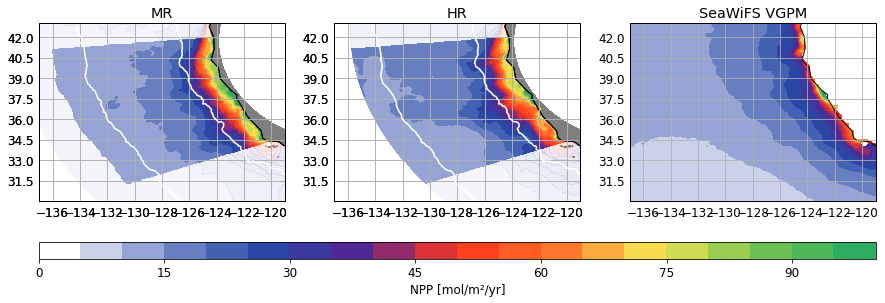

In [11]:
# plot lateral distribution and satellite data

fig, ax = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

plots = None

# loop runs
for i, name in enumerate(['pactcs30', 'pactcs15']):
    run = runs[name]
    
    # plot data
    _, plots = plot_data(run.grid, npp_int[name], ax=ax[i], highlight_subdomain=run.gruber_mask, lon_name='lon_rho', lat_name='lat_rho', vmin=0, vmax=100, as_contourfill=True, levels=20, cmap=get_step_cmap(W2G, 20), colorbar=False, land_gray=True, highlight_subdomain_alpha=0.1);
    
    # add distance lines
    for line in run.distance_lines:
        ax[i].plot(line[0], line[1], transform=ccrs.PlateCarree(), color='white')
    
    ax[i].set_title(names[name])
    
    # cut domain
    ax[i].set_ylim(30, 43)
    ax[i].set_xlim(-137, -119)
    ax[i].set_ylabel('Lat')
    ax[i].set_xlabel('Lon')

# plot seawif data
plot_data(ds_gruber_2011, seawifs_npp.mean(axis=0), ax=ax[2], lon_name='Lon', lat_name='Lat', vmin=0, vmax=100, cmap=get_step_cmap(W2G, 20), as_contourfill=True, colorbar=False)
ax[2].set_title('SeaWiFS VGPM')
ax[2].set_ylim(30, 43)
ax[2].set_xlim(-137, -119)

# add colorbar
plt.colorbar(plots[-1], ax=ax, orientation='horizontal', label='NPP [mol/m²/yr]', aspect=50) 

plt.savefig('figures/result_npp_domain.pdf')
plt.show()

## Productivity as a function of time and distance to coast (Hovmöller diagram)

In [12]:
def mean_within(data, run, lower_bound=0, upper_bound=np.inf):
    """
    Function to calculate the average of data within a given range of distance to coast.
    Only uses value inside `gruber_mask` and the average is weighted by the area of the grid cells.
    """
    # construct mask for data
    dist_grub = run.distance_map[run.gruber_mask]
    distance_mask = np.logical_and(dist_grub >= lower_bound, dist_grub < upper_bound)
    # get data in mask
    data_grub = data[run.gruber_mask][distance_mask]
    # get area in mask
    area_grub = run.area_map[run.gruber_mask][distance_mask]
    # handle nans
    mask = ~np.isnan(data_grub)
    return np.average(data_grub[mask], weights=area_grub[mask])

In [13]:
## build hovmöller data

# step size for hovmöller diagram. Corresponds to 20 steps from 0 to 1000km
km_step = 50

# the Hovmöller data is built by taking the average over all doys of a given month within a given range of distance to coast
# so the final dimension is years (5) x months (12) x distance to coast (20)

npp_hovm_interannual = {  ## loop pactcs30 and pactcs15
    name: np.array([  ## LOOP: years
        np.array([  ## LOOP: months
            np.array([  ## LOOP distance to coast
                # the temporal average (year and month) is calculated here, the spatial average (distance to coast) by function mean_within
                mean_within(
                    npp_int_t[name][year:year+1, t:t+15].mean(axis=(0, 1)),
                    runs[name],
                    i, i + km_step
                ) for i in range(0, 1000, km_step)  # ENDLOOP distance to coast
            ]) for t in range(0, 180, 15)  # ENDLOOP: months, only 15 days because bidaily
        ]) for year in range(5)  # ENDLOOP: years
    ]) for name in runs
}

In [14]:
# calculate average of year 3 to 5
npp_15 = npp_hovm_interannual['pactcs15'][2:].mean(axis=0)
npp_30 = npp_hovm_interannual['pactcs30'][2:].mean(axis=0)

#### Hovmöller Diagram

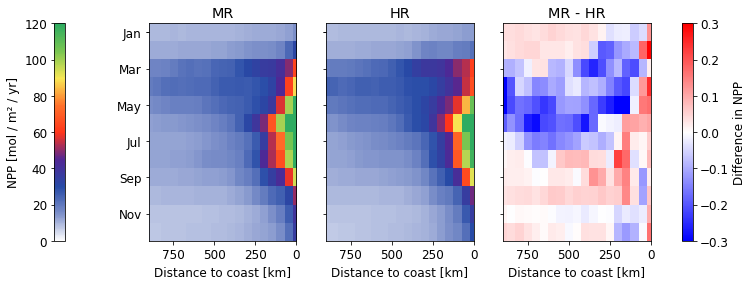

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# plot pactcs30
cax = ax[0].imshow(npp_30, vmin=0, vmax=120, cmap=W2G, aspect='auto')
# plot pactcs15
ax[1].imshow(npp_15, vmin=0, vmax=120, cmap=W2G, aspect='auto')
# calc difference
diff_percent = (npp_30 - npp_15)/npp_30
cax2 = ax[2].imshow(diff_percent, vmin=-.3, vmax=.3, cmap='bwr', aspect='auto')

# titles
ax[0].set_title('MR')
ax[1].set_title('HR')
ax[2].set_title('MR - HR')

# time labels
ax[0].set_yticks([0, 2, 4, 6, 8, 10, 0])
ax[0].set_yticklabels(['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov'])

# distance labels
xticks = [0, 5, 10, 15]
xticklabels = [0, 250, 500, 750]
ax[0].set_xlim(18, 0)
ax[1].set_xlim(18, 0)
ax[2].set_xlim(18, 0)
for i in range(3):
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(["{:.0f}".format(i) for i in xticklabels])
    ax[i].set_xlabel('Distance to coast [km]')

# colorbars
plt.colorbar(cax, ax=ax, label='NPP [mol / m² / yr]', location='left')
plt.colorbar(cax2, ax=ax, label='Difference in NPP', location='right')

plt.savefig('figures/result_npp_diff.pdf')
plt.show()

#### Relative Change of NPP

In [16]:
# assessing the error by interannual variability
d1_npp_hovm = {
    name: 0.5*np.abs(np.nanmax(npp_hovm_interannual[name][2:], axis=0) - np.nanmin(npp_hovm_interannual[name][2:], axis=0)) for name in npp_hovm_interannual
}

In [17]:
def ratio_of_mean_with_error(time_slice=slice(None, None)):
    """
    Calculate the ratio of summed NPP for a given time slice, propagate the error accordingly.
    """
    # create sums of npp for given time slice
    npp_sum_15, d_npp_sum_15 = mean_with_error(npp_15[time_slice], d1_npp_hovm['pactcs15'][time_slice], axis=0)
    npp_sum_30, d_npp_sum_30 = mean_with_error(npp_30[time_slice], d1_npp_hovm['pactcs30'][time_slice], axis=0)
    # calculate the ratio
    npp_rel, d_npp_rel = ratio_with_error(npp_sum_15, npp_sum_30, d_npp_sum_15, d_npp_sum_30)
    return npp_rel, d_npp_rel

In [18]:
npp_rel, d1_npp_rel = ratio_of_mean_with_error()

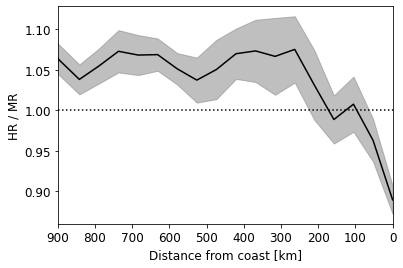

In [19]:
## plot aggregated change of NPP

fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 1000, npp_30.shape[1])
ax.errorbar(x, npp_rel, color='k')
#ax.fill_between(x, npp_rel + d2_npp_rel, npp_rel - d2_npp_rel, color='gray', alpha=0.3)
ax.fill_between(x, npp_rel + d1_npp_rel, npp_rel - d1_npp_rel, color='gray', alpha=0.5)
ax.axhline(1, ls=':', color='k')
ax.set_xlim(900, 0)
ax.set_xlabel('Distance from coast [km]')
ax.set_ylabel('HR / MR')

plt.savefig('figures/result_npp_reduction.pdf')
plt.show()

In [20]:
# calculate change of NPP during spring
npp_rel_spring, d1_npp_rel_spring = ratio_of_mean_with_error(slice(3, 6))

In [21]:
def print_nice_mean_error(descr, x, dx):
    m, d = mean_with_error(x, dx)
    print('{:s}: {:1.3f} + {:1.3f}'.format(descr, m, d))

In [22]:
print('Changes in NPP')
print_nice_mean_error('d2c < 200km', *mean_with_error(npp_rel[:4], d1_npp_rel[:4]))
print_nice_mean_error('d2c < 50km', *mean_with_error(npp_rel[:1], d1_npp_rel[:1]))
print_nice_mean_error('200km < d2c < 800km', *mean_with_error(npp_rel[4:16], d1_npp_rel[4:16]))
print_nice_mean_error('200km < d2c < 800km, spring', *mean_with_error(npp_rel_spring[4:16], d1_npp_rel_spring[4:16]))

Changes in NPP
d2c < 200km: 0.962 + 0.014
d2c < 50km: 0.890 + 0.017
200km < d2c < 800km: 1.060 + 0.009
200km < d2c < 800km, spring: 1.144 + 0.020


NPP is reduced in the nearshore region by $3.8 \pm 1.4\%$ and by $11.0 \pm 1.7\%$ within 50km. In the offshore region, NPP is enhanced by $6.0 \pm 0.9\%$ with the largest increase in spring ($14.4 \pm 2.0\%$).

## Model Drift

In [23]:
# flatten arrays to continous time, i.e. 5*182 x domain (width and height)
lol15 = npp_int_t['pactcs15'].reshape(-1, npp_int_t['pactcs15'].shape[2], npp_int_t['pactcs15'].shape[3])
lol30 = npp_int_t['pactcs30'].reshape(-1, npp_int_t['pactcs30'].shape[2], npp_int_t['pactcs30'].shape[3])

In [24]:
# calculate average npp within 200 to 800km for pactcs15
k_off = np.nanmean(lol15[:, np.logical_and(runs['pactcs15'].gruber_mask, np.logical_and(
    runs['pactcs15'].distance_map >= 200, runs['pactcs15'].distance_map < 800
))], axis=1)
# calculate average npp within 200 to 800km for pactcs30
p_off = np.nanmean(lol30[:, np.logical_and(runs['pactcs30'].gruber_mask, np.logical_and(
    runs['pactcs30'].distance_map >= 200, runs['pactcs30'].distance_map < 800
))], axis=1)

# calculate average npp within 200km for pactcs15
k_coast = np.nanmean(lol15[:, np.logical_and(runs['pactcs15'].gruber_mask, runs['pactcs15'].distance_map < 200)], axis=1)
# calculate average npp within 200km for pactcs30
p_coast = np.nanmean(lol30[:, np.logical_and(runs['pactcs30'].gruber_mask, runs['pactcs30'].distance_map < 200)], axis=1)

/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/nfs/kryo/work/max

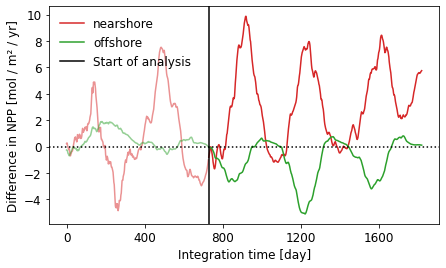

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# position to put vertical bar --> denotes the years which were dropped from analysis
r = 2*182

# calculate difference between nearshore npp with 120 days (bidaily!) filter
k_1 = np_rolling_mean(p_coast[:910] - k_coast, 60)
# plot first two years
ax.plot(np.arange(r), k_1[:r], color='C3', alpha=0.5)
# plot last three years
ax.plot(np.arange(3*182)+r, k_1[2*182:], color='C3', label='nearshore')

# calculate difference between offshore npp with 120 days (bidaily!) filter
k_2 = np_rolling_mean(p_off[:910] - k_off, 60)
# plot first two years
ax.plot(np.arange(r), k_2[:r], color='C2', alpha=0.5)
# plot last three years
ax.plot(np.arange(3*182)+r, k_2[r:], color='C2', label='offshore')

# add vertical bar
ax.axvline(r, color='k', label='Start of analysis')
# add line at 0
ax.axhline(0, color='k', ls=':')

# x axis (integration time)
ax.set_xticks([0, 200, 400, 600, 800])
ax.set_xticklabels([0, 400, 800, 1200, 1600])
ax.set_xlabel('Integration time [day]')

# y axis
ax.set_ylabel('Difference in NPP [mol / m² / yr]')

ax.legend(frameon=False)

plt.savefig('figures/result_npp_drift.pdf')
plt.show()